# Segmentacja obrazu za pomocą DeepLabV3 na zbiorze danych VOCSegmentation z interfejsem Gradio

W tym notebooku użyjemy wstępnie wytrenowanego modelu DeepLabV3 do segmentacji obrazów, dostosujemy go do zbioru danych VOCSegmentation i stworzymy interfejs Gradio do interakcji z modelem.

## Importowanie bibliotek

Najpierw zaimportujemy niezbędne biblioteki.


In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import VOCSegmentation
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn
import torch.optim as optim
import gradio as gr
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


## Definiowanie transformacji i ładowanie danych

Zdefiniujemy niezbędne transformacje i załadujemy zbiór danych VOCSegmentation.


In [16]:
# Define transformations for input images and target masks
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# Load the VOC Segmentation dataset
dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


## Ustawianie wstępnie wytrenowanego modelu

Załadujemy wstępnie wytrenowany model DeepLabV3 i dostosujemy go do zadania segmentacji.


In [17]:
# Load the pre-trained DeepLabV3 model
model = deeplabv3_resnet50(pretrained=True)

# Modify the final classifier layer to match the number of classes in VOCSegmentation
num_classes = 21  # VOCSegmentation has 21 classes including background
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


## Trenowanie modelu

Zdefiniujemy funkcję straty, optymalizator oraz pętlę trenowania, śledząc zarówno dokładność, jak i stratę podczas trenowania i walidacji.


In [18]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop function
def train_model(model, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.squeeze(1).long().to(device)  # Ensure labels are single-channel and long type

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)['out']  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize the model

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.squeeze(1).long().to(device)  # Ensure labels are single-channel and long type
                outputs = model(inputs)['out']
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Train the model
train_model(model, optimizer)


Epoch [1/5], Train Loss: 0.6389, Validation Loss: 0.2729
Epoch [2/5], Train Loss: 0.2489, Validation Loss: 0.2233
Epoch [3/5], Train Loss: 0.2125, Validation Loss: 0.1990
Epoch [4/5], Train Loss: 0.1944, Validation Loss: 0.1873
Epoch [5/5], Train Loss: 0.1831, Validation Loss: 0.1805


## Zapisywanie wytrenowanego modelu

Zapiszemy wytrenowany model, aby można było go później używać.


In [19]:
# Save the trained model
torch.save(model.state_dict(), 'deeplabv3_vocsegmentation.pth')


## Ładowanie wytrenowanego modelu i segmentacja obrazu

Załadujemy wytrenowany model, przeprowadzimy segmentację obrazu i wyświetlimy wyniki.


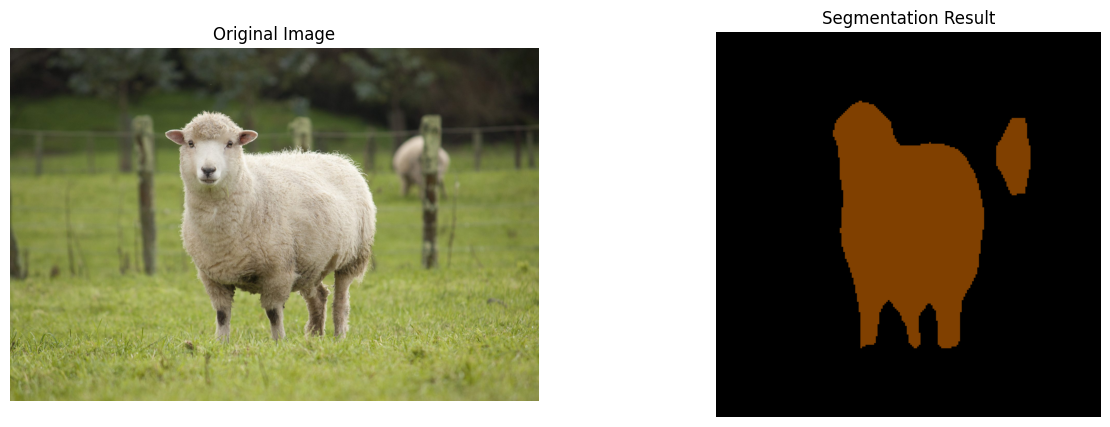

In [32]:
# Load the pre-trained DeepLabV3 model
model = deeplabv3_resnet50(pretrained=True)
model.eval()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the color map for segmentation classes
VOC_COLORMAP = np.array([
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
    [0, 64, 128]
])

def decode_segmentation_mask(mask, colormap):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    
    for l in range(0, len(colormap)):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

# Define the transformation for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = "asd.jpg"  # Change this to the path of your image
image = Image.open(image_path)
input_image = transform(image).unsqueeze(0).to(device)

# Perform the segmentation
with torch.no_grad():
    output = model(input_image)['out']
output = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

# Convert the segmentation mask to an RGB image
segmentation_mask = decode_segmentation_mask(output, VOC_COLORMAP)

# Display the original image and the segmentation result
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(segmentation_mask)
ax[1].set_title("Segmentation Result")
ax[1].axis('off')

plt.show()
